## **Mengimport Modul**

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.feature_selection import RFECV

import xgboost as xgb
from xgboost import cv, DMatrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score

## **Membaca Data**

In [26]:
data = pd.read_csv("../Data/hypertension_data.csv")
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,57.0,1.0,3,145,233,1,0,150,0,2.3,0,0,1,1
1,64.0,0.0,2,130,250,0,1,187,0,3.5,0,0,2,1
2,52.0,1.0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56.0,0.0,1,120,236,0,1,178,0,0.8,2,0,2,1
4,66.0,0.0,0,120,354,0,1,163,1,0.6,2,0,2,1


## **Preprocessing Data**

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26083 entries, 0 to 26082
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       26083 non-null  float64
 1   sex       26058 non-null  float64
 2   cp        26083 non-null  int64  
 3   trestbps  26083 non-null  int64  
 4   chol      26083 non-null  int64  
 5   fbs       26083 non-null  int64  
 6   restecg   26083 non-null  int64  
 7   thalach   26083 non-null  int64  
 8   exang     26083 non-null  int64  
 9   oldpeak   26083 non-null  float64
 10  slope     26083 non-null  int64  
 11  ca        26083 non-null  int64  
 12  thal      26083 non-null  int64  
 13  target    26083 non-null  int64  
dtypes: float64(3), int64(11)
memory usage: 2.8 MB


In [28]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,26083.0,55.661389,15.189768,11.0,44.0,56.0,67.0,98.0
sex,26058.0,0.500000,0.500010,0.0,0.0,0.5,1.0,1.0
cp,26083.0,0.958594,1.023931,0.0,0.0,1.0,2.0,3.0
trestbps,26083.0,131.592992,17.588809,94.0,120.0,130.0,140.0,200.0
chol,26083.0,246.246061,51.643522,126.0,211.0,240.0,275.0,564.0
fbs,26083.0,0.149753,0.356836,0.0,0.0,0.0,0.0,1.0
restecg,26083.0,0.526512,0.525641,0.0,0.0,1.0,1.0,2.0
thalach,26083.0,149.655024,22.858109,71.0,133.0,153.0,166.0,202.0
exang,26083.0,0.326573,0.468969,0.0,0.0,0.0,1.0,1.0
oldpeak,26083.0,1.039512,1.165138,0.0,0.0,0.8,1.6,6.2


In [29]:
##Mengecek nilai kosong (missing value)
data.isna().sum()

age          0
sex         25
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
target       0
dtype: int64

In [30]:
data = data.dropna()
data.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [31]:
##Mengubah tipe kolom
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']
data[categorical_columns] = data[categorical_columns].astype('category')

In [32]:
##Menyeleksi variabel (feature selection)
X = data.drop(["target"], axis = 1)
y = data["target"]

estimator = DecisionTreeClassifier(max_depth=5,min_samples_split=100)
rfecv = RFECV(estimator=estimator, cv=StratifiedKFold(10, random_state=42, shuffle=True), scoring="accuracy")
rfecv.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
      estimator=DecisionTreeClassifier(max_depth=5, min_samples_split=100),
      scoring='accuracy')

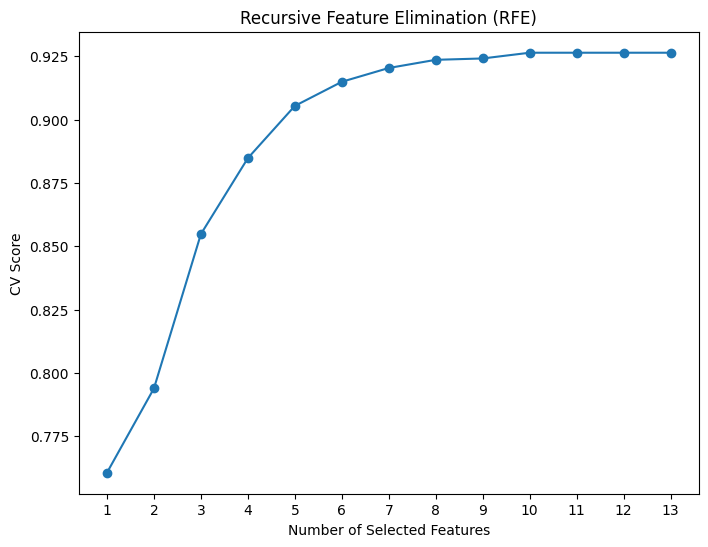

The optimal number of features: 10


In [33]:
##Plot RFE
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], marker='o')
plt.xticks(range(1, X.shape[1] + 1))
plt.xlabel("Number of Selected Features")
plt.ylabel("CV Score")
plt.title("Recursive Feature Elimination (RFE)")
plt.show()

print("The optimal number of features: {}".format(rfecv.n_features_))

In [34]:
##Prediktor terpilih
selected_features = X.columns[rfecv.support_]
X_selected = X[selected_features]

In [35]:
data['target'].value_counts()

target
1    14274
0    11784
Name: count, dtype: int64

In [36]:
##Membagi data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

In [37]:
##Mengatasi imbalance data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [38]:
X_train.head()

,cp,trestbps,chol,restecg,thalach,exang,oldpeak,slope,ca,thal
0,1,120,236,1,178,0,0.8,2,0,2
1,3,160,273,0,125,0,0.0,2,0,2
2,3,145,233,0,150,0,2.3,0,0,1
3,3,110,211,0,144,1,1.8,1,0,2
4,2,130,231,1,146,0,1.8,1,3,3


In [39]:
y_train.head()

0    1
1    0
2    1
3    1
4    1
Name: target, dtype: category
Categories (2, int64): [0, 1]

In [40]:
##Menstandarisasi data
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## **Melakukan Klasifikasi**

In [41]:
xg = xgb.XGBClassifier(n_estimators=350)
xg.fit(X_train, y_train)
xg_preds = xg.predict(X_test)
print(classification_report(y_test, xg_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2357
           1       1.00      1.00      1.00      2855

    accuracy                           1.00      5212
   macro avg       1.00      1.00      1.00      5212
weighted avg       1.00      1.00      1.00      5212



## **XGBoost dan Cross Validation**

In [42]:
# Inisialisasi data dan parameter
params = {
    "objective": "binary:logistic",
    "colsample_bytree": 0.3,
    "learning_rate": 0.1,
    "max_depth": 10,
    "alpha": 10,
}
data_dmatrix = DMatrix(data=X_train, label=y_train)  # Ganti X_train dan y_train sesuai data Anda

# List untuk menyimpan hasil dari masing-masing nfold
nfolds = [3, 5, 10]
best_results = {}

for n in nfolds:
    # Menjalankan cross-validation untuk setiap nilai nfold
    xgb_cv = cv(
        dtrain=data_dmatrix,
        params=params,
        nfold=n,
        num_boost_round=50,  # Jumlah iterasi yang digunakan selama cross-validation
        early_stopping_rounds=10,
        metrics="auc",
        as_pandas=True,
        seed=42,
    )
    
    # Menyimpan iterasi terbaik berdasarkan AUC
    best_iteration = xgb_cv['test-auc-mean'].idxmax()
    best_auc = xgb_cv['test-auc-mean'].iloc[best_iteration]
    # Tidak perlu menambahkan n_estimators dalam params, gunakan num_boost_round
    best_num_boost_round = best_iteration  # Gunakan jumlah iterasi terbaik
    
    # Membuat model dengan jumlah estimators terbaik
    model = xgb.XGBClassifier(**params, n_estimators=best_num_boost_round)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Menghitung recall pada data uji
    recall = recall_score(y_test, y_pred)
    best_results[n] = {
        'best_iteration': best_iteration,
        'recall': recall,
        'xgb_cv': xgb_cv
    }
    
    print(f"nfold = {n}")
    print(f"Best Recall: {recall} at iteration {best_iteration}")
    
    # Menampilkan classification report untuk nfold ini
    print(f"Classification report for nfold = {n}:")
    print(classification_report(y_test, y_pred))
    print("="*50)

# Menentukan nfold dengan recall terbaik
best_nfold = max(best_results, key=lambda x: best_results[x]['recall'])
print(f"nfold terbaik berdasarkan Recall adalah: {best_nfold} dengan Recall {best_results[best_nfold]['recall']}")

nfold = 3
Best Recall: 1.0 at iteration 31
Classification report for nfold = 3:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2357
           1       1.00      1.00      1.00      2855

    accuracy                           1.00      5212
   macro avg       1.00      1.00      1.00      5212
weighted avg       1.00      1.00      1.00      5212

nfold = 5
Best Recall: 1.0 at iteration 28
Classification report for nfold = 5:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2357
           1       1.00      1.00      1.00      2855

    accuracy                           1.00      5212
   macro avg       1.00      1.00      1.00      5212
weighted avg       1.00      1.00      1.00      5212

nfold = 10
Best Recall: 1.0 at iteration 30
Classification report for nfold = 10:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      

## **Membuat Confussion Matrix**

In [43]:
# Membuat model terbaik berdasarkan nfold terbaik dan iterasi terbaik
best_iteration = best_results[best_nfold]['best_iteration']
params['n_estimators'] = best_iteration  # Set n_estimators ke iterasi terbaik

In [44]:
# Latih model dengan data pelatihan
model_best = xgb.XGBClassifier(**params)
model_best.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=31, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=10, ...)

In [45]:
# Prediksi data uji
y_pred_best = model_best.predict(X_test)

In [46]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2357
           1       1.00      1.00      1.00      2855

    accuracy                           1.00      5212
   macro avg       1.00      1.00      1.00      5212
weighted avg       1.00      1.00      1.00      5212



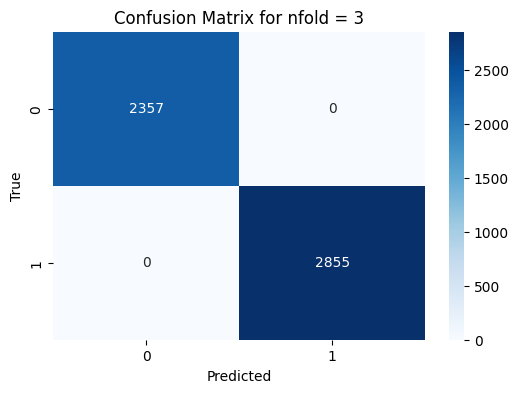

In [47]:
# Menghitung dan menampilkan confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)

# Visualisasi confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for nfold = {best_nfold}')
plt.show()

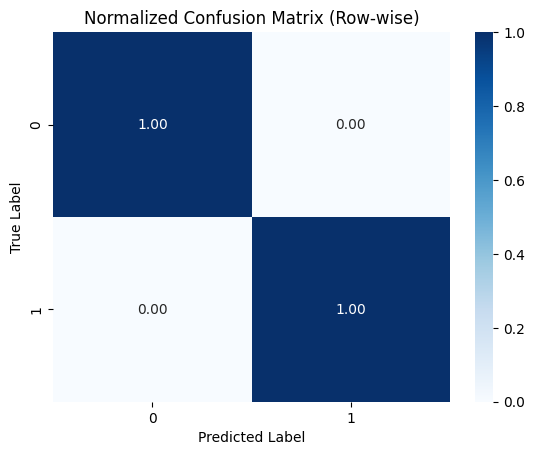

In [48]:
##Membuat confussion matrix yang dinormalisasi
def normalize_confusion_matrix(cm, norm='true'):
    if norm == 'true':
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    elif norm == 'pred':
        cm_normalized = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
    elif norm == 'all':
        cm_normalized = cm.astype('float') / cm.sum()
    else:
        raise ValueError("Unknown normalization type. Use 'true', 'pred', or 'all'.")
    
    return cm_normalized

cm = confusion_matrix(y_test, y_pred_best)
cm_normalized = normalize_confusion_matrix(cm, norm='true')

# Plotting
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
plt.title('Normalized Confusion Matrix (Row-wise)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## **Menyimpan Model**

In [49]:
import joblib
import os

# Tentukan path folder spesifik
folder_path = "./Output_Model"
os.makedirs(folder_path, exist_ok=True)  # Buat folder jika belum ada

# Simpan model XGBoost ke folder spesifik
joblib.dump(model_best, os.path.join(folder_path, 'xgboost_ht.pkl'))

['./Output_Model\\xgboost_ht.pkl']